# Cats vs Dogs

## Initialisations

In [1]:
# Directive pour afficher les graphiques dans Jupyter
%matplotlib inline

# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn import datasets

In [2]:
from keras.datasets import mnist

from keras.models import Sequential, load_model

from keras.layers import Dense, Dropout, Flatten

from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
# Permet d'éviter les erreurs mémoires pour le GPU
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [4]:
def plot_scores(train) :
    accuracy = train.history['acc']
    val_accuracy = train.history['val_acc']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

## Importation des images

On utilise *ImageDataGenerator*, à la fois pour charger les images à partir d'un répertoire, et pour augmenter le nombre d'images.

On augmente le nombre d'images en appliquant des transformations simples (rotation, retournement, décalage, ...)
- **rotation_range** est une valeur en degrés (0-180), une plage à l'intérieur de laquelle les images peuvent tourner aléatoirement
- **width_shift** et **height_shift** sont des plages (en tant que fraction de la largeur ou de la hauteur totale) dans lesquelles les images peuvent être traduites aléatoirement verticalement ou horizontalement.
- **rescale** est une valeur par laquelle nous allons multiplier les données avant tout autre traitement. Nos images originales consistent en des coefficients RVB dans le 0-255, mais ces valeurs seraient trop élevées pour que nos modèles puissent les traiter (compte tenu d'un taux d'apprentissage typique), alors nous ciblons des valeurs entre 0 et 1 en utilisant plutôt un facteur 1/255.
- **shear_range** est pour l'application aléatoire de transformations de cisaillement
- **zoom_range** est pour zoomer aléatoirement à l'intérieur des images
- **horizontal_flip** est pour retourner aléatoirement la moitié des images horizontalement --pertinent quand il n'y a pas de suppositions d'asymétrie horizontale (par exemple, des images du monde réel).
- **fill_mode** est la stratégie utilisée pour remplir les pixels nouvellement créés, qui peuvent apparaître après une rotation ou un décalage largeur/hauteur.



In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        rescale=1./255)

*flow_from_directory* permet de lire les images directement à partir d'un répertoire.  
Ici les images d'apprentissage sont dans un répertoire **CatsDogs2\train*

In [1]:
train_generator = train_datagen.flow_from_directory(
    directory="CatsDogs2\\train",
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

NameError: name 'train_datagen' is not defined

In [7]:
valid_generator = valid_datagen.flow_from_directory(
    directory="CatsDogs2\\valid",
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 899 images belonging to 2 classes.


In [9]:
print(valid_generator[0][0])

[[[[0.34901962 0.2627451  0.21176472]
   [0.38823533 0.21960786 0.09411766]
   [0.38823533 0.21568629 0.11764707]
   ...
   [0.9450981  0.9450981  0.91372555]
   [0.95294124 0.9490197  0.94117653]
   [0.94117653 0.93725497 0.9294118 ]]

  [[0.39607847 0.21960786 0.09019608]
   [0.38823533 0.227451   0.10980393]
   [0.41960788 0.2627451  0.16078432]
   ...
   [0.6901961  0.61960787 0.5254902 ]
   [0.7019608  0.6313726  0.54509807]
   [0.7254902  0.654902   0.5686275 ]]

  [[0.34117648 0.20000002 0.10588236]
   [0.40000004 0.24705884 0.13333334]
   [0.35686275 0.21176472 0.10588236]
   ...
   [0.8588236  0.7843138  0.7294118 ]
   [0.86274517 0.78823537 0.73333335]
   [0.85098046 0.77647066 0.72156864]]

  ...

  [[0.44705886 0.47450984 0.44705886]
   [0.4431373  0.427451   0.4156863 ]
   [0.47058827 0.427451   0.41176474]
   ...
   [0.7843138  0.78823537 0.7960785 ]
   [0.77647066 0.7803922  0.8000001 ]
   [0.7960785  0.8000001  0.8196079 ]]

  [[0.4039216  0.427451   0.41176474]
   [0.3

In [8]:
print(train_generator.n)

1000


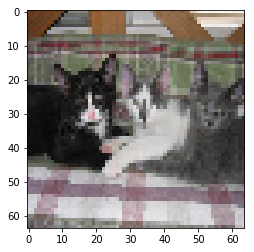

In [9]:
plt.imshow(*valid_generator[0][0])

In [10]:
print(valid_generator[0][1])

[[1. 0.]]


## Modèle CNN

On teste un modèle avec deux couches convolutionnelles :

In [11]:
# Modèle CNN plus profond
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

Le nombres d'images générées à chaque epoch est *steps_by_epoch x batch_size*. Ici on génère 10 fois plus d'images à partir du dataset d'apprentissage (ce qui ralentit évidemment l'apprentissage)

In [13]:
STEP_SIZE_TRAIN=10*train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
312/312 [==============================] - 61s 196ms/step - loss: 0.6649 - acc: 0.5895 - val_loss: 0.5519 - val_acc: 0.7152
Epoch 2/10
312/312 [==============================] - 59s 188ms/step - loss: 0.5315 - acc: 0.7278 - val_loss: 0.5664 - val_acc: 0.6952
Epoch 3/10
312/312 [==============================] - 58s 185ms/step - loss: 0.4373 - acc: 0.7944 - val_loss: 0.4297 - val_acc: 0.7953
Epoch 4/10
312/312 [==============================] - 55s 177ms/step - loss: 0.3310 - acc: 0.8526 - val_loss: 0.4145 - val_acc: 0.8309
Epoch 5/10
312/312 [==============================] - 56s 179ms/step - loss: 0.2151 - acc: 0.9120 - val_loss: 0.3925 - val_acc: 0.8476
Epoch 6/10
312/312 [==============================] - 58s 187ms/step - loss: 0.1446 - acc: 0.9458 - val_loss: 0.4363 - val_acc: 0.8732
Epoch 7/10
312/312 [==============================] - 56s 180ms/step - loss: 0.1033 - acc: 0.9634 - val_loss: 0.4530 - val_acc: 0.8754
Epoch 8/10
312/312 [==============================] - 5

In [56]:
model.evaluate_generator(generator=valid_generator)

[0.5509581570814253, 0.8598442714126807]

In [17]:
# Prediction
y_pred = model.predict_generator(valid_generator,verbose=1).argmax(axis=-1)

899/899 [==============================] - 4s 4ms/step


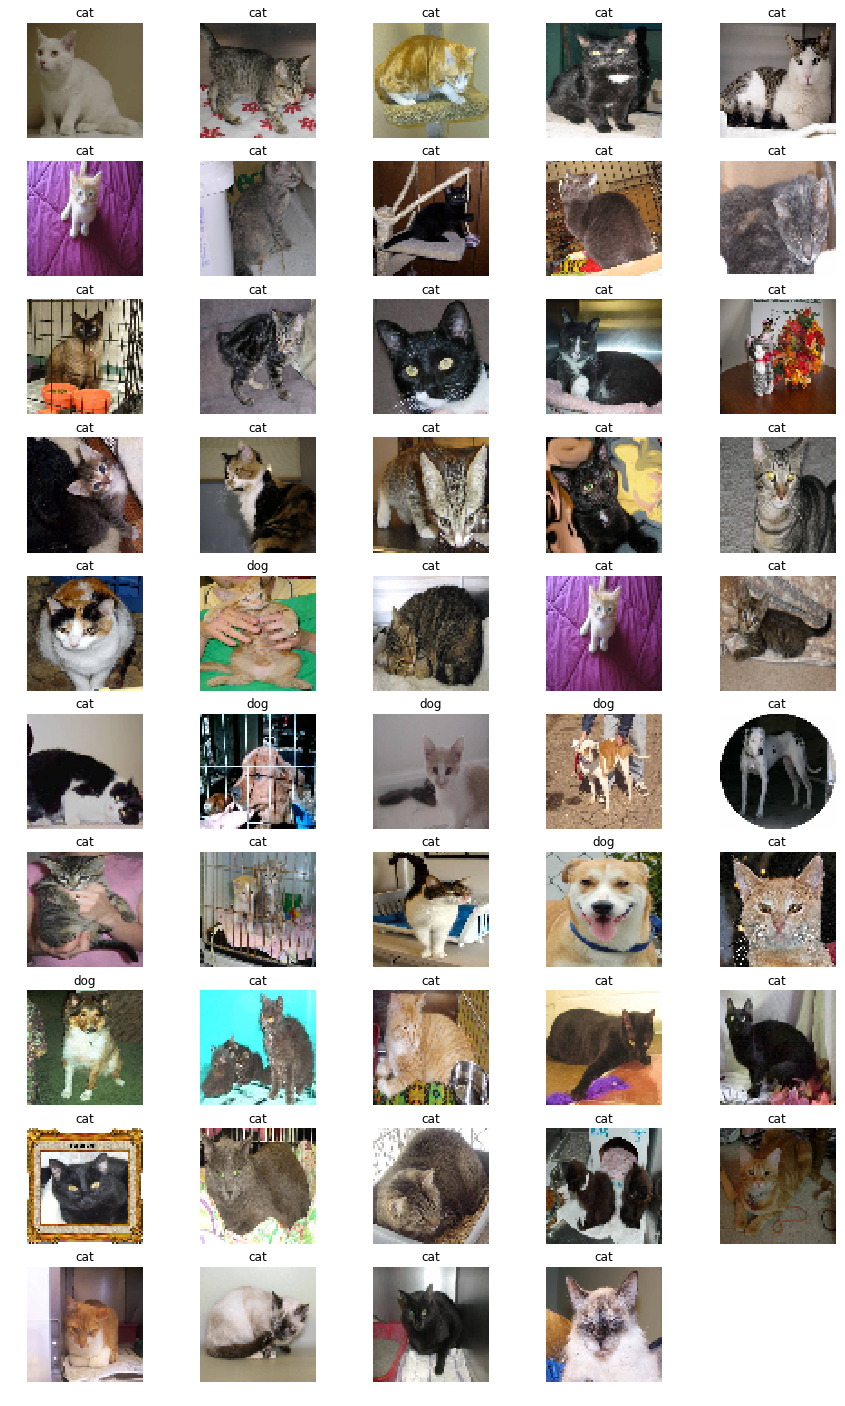

In [49]:
import random

labels = ['cat','dog']
plt.figure(figsize=(15,25))
n_test = 899
for i in range(1,50) :
    ir = random.randint(0,n_test)
    plt.subplot(10,5,i)
    plt.axis('off')
    plt.imshow(*valid_generator[ir][0])
    plt.title(labels[y_pred[ir]])
#    plt.title('%s / %s' % (y_cnn_classe[ir], y_test_classe[ir]))

In [31]:
# Modèle VGG16

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(64, 64, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 256)       295168    
__________

In [33]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
31/31 [==============================] - 10s 321ms/step - loss: 0.7029 - acc: 0.4962 - val_loss: 0.7060 - val_acc: 0.2214
Epoch 2/10
31/31 [==============================] - 5s 149ms/step - loss: 0.6933 - acc: 0.5099 - val_loss: 0.6978 - val_acc: 0.2214
Epoch 3/10
31/31 [==============================] - 5s 156ms/step - loss: 0.6932 - acc: 0.5041 - val_loss: 0.6998 - val_acc: 0.2214
Epoch 4/10
31/31 [==============================] - 5s 149ms/step - loss: 0.6935 - acc: 0.4768 - val_loss: 0.6926 - val_acc: 0.7786
Epoch 5/10
31/31 [==============================] - 5s 150ms/step - loss: 0.6931 - acc: 0.5122 - val_loss: 0.6905 - val_acc: 0.7786
Epoch 6/10
31/31 [==============================] - 5s 153ms/step - loss: 0.6933 - acc: 0.4668 - val_loss: 0.6924 - val_acc: 0.7786
Epoch 7/10
31/31 [==============================] - 5s 150ms/step - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6953 - val_acc: 0.2214
Epoch 8/10
31/31 [==============================] - 5s 150ms/step - loss: 0

In [34]:
model.evaluate_generator(generator=valid_generator)

[0.6882798425082503, 0.778642936662519]